In [1]:
import os 
import sys
sys.path.append("../galess")
import lens_stat as ls
import ls_utils as utils
import lens_plot

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
M_array     = np.linspace(-13 , -25 , 25)
sigma_array = np.linspace(100 , 400 , 31)
zl_array    = np.linspace(0.  , 2.5 , 26)
zs_array    = np.linspace(0.  , 10  , 21)
min_SNR     = 20
arc_mu_thr  = 3

title    = 'EUCLID Wide VIS'
limit    = 26.2
cut      = 25
area     = 15000
seeing   = 0.17
exp_time_sec = 1610
pixel_arcsec = 0.1
zero_point_m = 25.5
sky_bckgnd_m = 22.2
photo_band  = 'sdss_i0'

title    = 'EUCLID Wide VIS'
try:
     matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
except ValueError:
    print('RUNNING MODEL')
    noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                sigma_array, zl_array, zs_array, M_array, limit, area, 
                                                                seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, pixel_arcsec, 
                                                                photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                LENS_LIGHT_FLAG = False, SIE_FLAG = True)

    LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                sigma_array, zl_array, zs_array, M_array, limit, area, 
                                                                seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, pixel_arcsec, 
                                                                photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                LENS_LIGHT_FLAG = True, SIE_FLAG = False)

    utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)

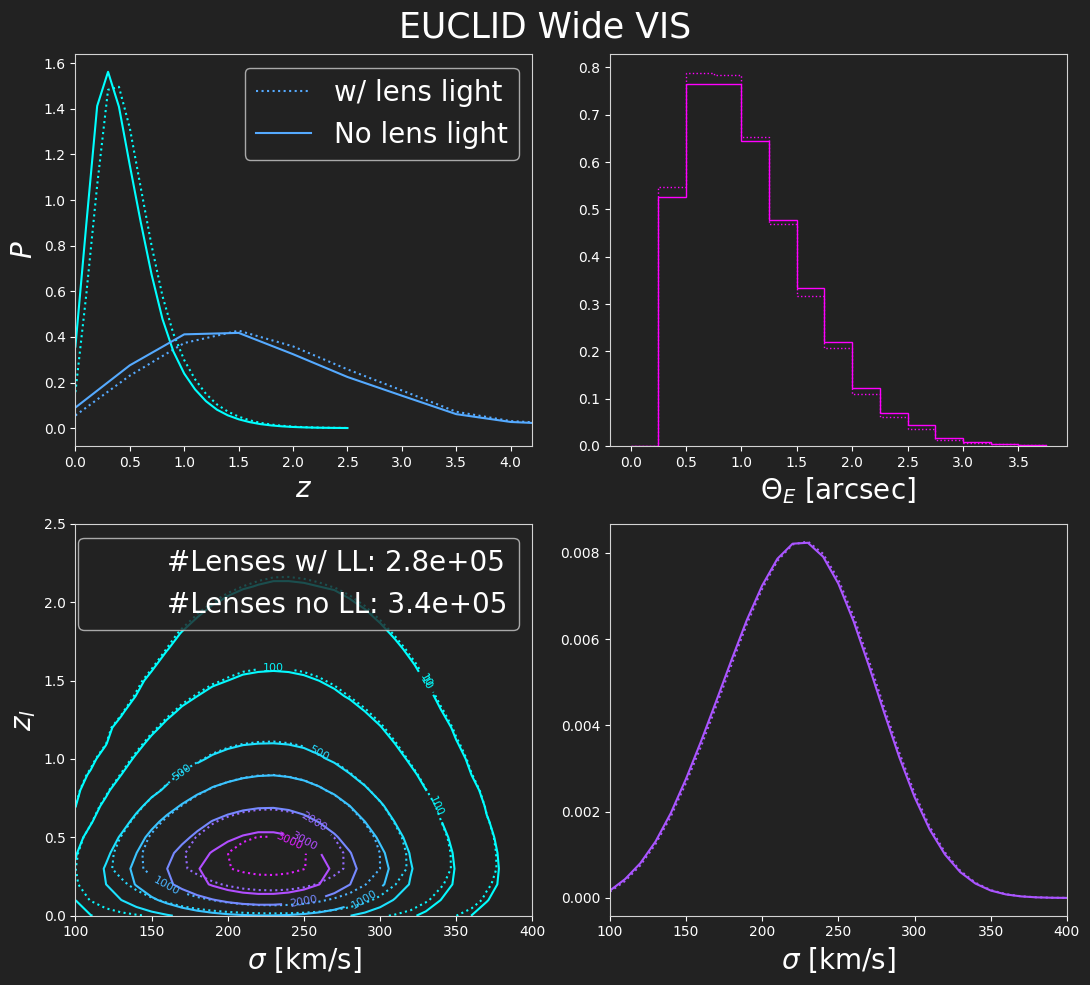

In [3]:
_PLOT_FOR_KEYNOTE = 1
lens_plot.set_plt_param(PLOT_FOR_KEYNOTE = _PLOT_FOR_KEYNOTE)
fig, ax = plt.subplots(2, 2, figsize=(11, 10), sharex=False, sharey=False)
plt.subplots_adjust(wspace=.15, hspace=.2)
lens_plot.plot_z_sigma_distributions(fig, ax, title, zl_array, zs_array, sigma_array,
                               Theta_E_LL, matrix_LL, Theta_E_noLL, matrix_noLL,
                               PLOT_FOR_KEYNOTE = _PLOT_FOR_KEYNOTE, LOG = 0, SMOOTH = 1, SAVE = 0)
plt.show()